### Week2-1 빅데이터기반의사결정사례 2: 감성분석

### 0. 라이브러리 

In [1]:
# 필수 데이터 분석 라이브러리
import pandas as pd
import numpy as np

# 데이터 세트 분할 함수
from sklearn.model_selection import train_test_split

# 텍스트 임베딩 및 전처리 함수
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 평가지표 함수 (정밀도, 재현율, F1 점수, 정확도)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# 케라스 함수
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Conv1D, MaxPool1D, concatenate, Flatten
from tensorflow.keras.optimizers import Adam

# 시각화 라이브러리
import matplotlib.pyplot as plt

### 1. 데이터 로드

In [2]:
# 데이터세트 로드
df = pd.read_csv('sample_amazon.csv')
# 데이터프레임의 크기 출력 (행, 열)
print(df.shape)
# 데이터프레임의 상위 5개 행 출력
df.head()

(179248, 4)


,reviewerID,asin,reviewText,overall
0,AAKKVN6IJJKO1,098949232X,This is one of the best calendars that you can...,5.0
1,A3N778P1L4YH9Y,7391002801,Case is cheaply made. If you aren't using an a...,1.0
2,A34GGU76V8AE5T,7887421268,I was very excited to find a really cute cover...,2.0
3,A2FZ0P2S6KCJ5P,8288862993,"I purchased this car charger ""Samsung Official...",1.0
4,A2G6OURH28WI8R,9638762632,The PowerBear HTC One M9 Battery Case is absol...,4.0


### 2. 데이터 레이블 전처리

In [3]:
# 레이블 처리: overall 점수가 3 이상이면 긍정(1), 그렇지 않으면 부정(0)으로 레이블링
df['label'] = df['overall'].apply(lambda x: 1 if x >= 3 else 0)
df.head()  # 변경 후 상위 5개 행 출력

,reviewerID,asin,reviewText,overall,label
0,AAKKVN6IJJKO1,098949232X,This is one of the best calendars that you can...,5.0,1
1,A3N778P1L4YH9Y,7391002801,Case is cheaply made. If you aren't using an a...,1.0,0
2,A34GGU76V8AE5T,7887421268,I was very excited to find a really cute cover...,2.0,0
3,A2FZ0P2S6KCJ5P,8288862993,"I purchased this car charger ""Samsung Official...",1.0,0
4,A2G6OURH28WI8R,9638762632,The PowerBear HTC One M9 Battery Case is absol...,4.0,1


In [4]:
# 레이블 분포 확인
df['label'].value_counts()

label
1    118013
0     61235
Name: count, dtype: int64

In [5]:
# 긍정과 부정 레이블이 균일한 분포를 갖도록 샘플링
df_pos = df[df['label'] == 1].sample(50000)  # 긍정 리뷰 50000개 샘플링
df_neg = df[df['label'] == 0].sample(50000)  # 부정 리뷰 50000개 샘플링

In [6]:
# 긍정과 부정 리뷰 결합하여 새로운 데이터 세트 생성
df_concat = pd.concat([df_pos, df_neg])
df_concat.reset_index(drop=True, inplace=True)  # 인덱스 초기화
df_concat.head()  # 변경 후 상위 5개 행 출력

,reviewerID,asin,reviewText,overall,label
0,A1TY7UHI7SCS94,B00V2WP48I,I bought this case as a gift for my father bec...,5.0,1
1,AZSHWVT62JV0V,B00WLLASZ8,Perfect,5.0,1
2,A2KSM6SIFCC03H,B01G5YRZFC,I just got this case. This is a cool case that...,5.0,1
3,A35FCQOUNFX0LD,B018QO1RHG,"I purchased this for my galaxy go prime, it fi...",3.0,1
4,ARVEHT2G8BX3J,B00TF5TJLW,I bought these because I wanted some to match ...,5.0,1


### 3. 데이터 세트 분할

In [7]:
# 데이터 분할 및 입력 데이터 추출 함수 정의
def data_split(df_sample_concat):

    # 데이터를 훈련용과 테스트용으로 분할하고 라벨 비율을 유지하기 위해 stratify를 사용
    df_train, df_test = train_test_split(df_sample_concat, test_size=0.2, random_state=42,  stratify=df_sample_concat["label"])

    # 훈련 데이터와 테스트 데이터에서 리뷰 텍스트와 라벨을 추출
    x_train = df_train['reviewText']
    y_train = np.array(df_train['label'])

    x_test = df_test['reviewText']
    y_test = np.array(df_test['label'])

    return x_train, x_test, y_train,  y_test

In [8]:
# 데이터 세트 분할
x_train, x_test, y_train,  y_test = data_split(df_concat)

### 4. 텍스트 임베딩 및 토큰화

In [9]:
# 문장을 단어 단위로 토큰화
def tokenize_text(text):
    return word_tokenize(text.lower())

# x_train을 토큰화하여 각 문장을 단어의 리스트로 변환
tokenized_x_train = x_train.apply(tokenize_text)

# Word2Vec 모델 훈련
w2v = Word2Vec(sentences=tokenized_x_train, vector_size=100, window=5, min_count=1, workers=4)

w2v.wv.vectors.shape

(66110, 100)

In [13]:
def tokenize_and_create_embedding_matrix(train_text, test_text, max_words=10000, max_sequence_length=100):

    # 토크나이저 초기화 (OOV 토큰 포함)
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    
    # 훈련 데이터에 토크나이저를 적용해 학습
    tokenizer.fit_on_texts(train_text)
    
    # 텍스트 데이터를 시퀀스로 변환
    train_sequences = tokenizer.texts_to_sequences(train_text)
    test_sequences = tokenizer.texts_to_sequences(test_text)
    
    # 시퀀스 패딩 처리 (post 방식 사용)
    padded_train_text = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
    padded_test_text = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')
    
    # 단어 인덱스 맵 생성 및 임베딩 행렬 준비
    word_index = tokenizer.word_index
    total_words = min(max_words, len(word_index))
    embedding_matrix = np.zeros((total_words + 1, 100))  # 임베딩 차원을 100으로 가정

    # Word2Vec 모델에서 단어에 해당하는 벡터를 임베딩 행렬에 할당
    for word, i in word_index.items():
        if i > max_words:
            continue
        if word in w2v.wv:
            embedding_matrix[i] = w2v.wv[word]

    # 임베딩 행렬의 크기 출력
    print(embedding_matrix.shape)

    # 패딩 처리된 텍스트 데이터와 임베딩 행렬, 사용된 총 단어 수, 시퀀스 최대 길이 반환
    return padded_train_text, padded_test_text, embedding_matrix, total_words, max_sequence_length

In [14]:
# 데이터 세트 분할
train_text, test_text, embedding_matrix, total_words, max_sequence_length = tokenize_and_create_embedding_matrix(x_train, x_test, max_words=100000, max_sequence_length=100)

(50331, 100)


### 5. 모델 구축

In [15]:
# 입력 레이어
text_input = Input(shape=(100,), name='Input_Text')

# 임베딩 레이어
embedding_layer = Embedding(input_dim=total_words+1, output_dim=100, weights=[embedding_matrix],
                            input_length=max_sequence_length, trainable=True, name='Embedding_text')(text_input)

# 합성곱과 MaxPooling 레이어를 여러 크기의 커널을 사용하여 생성
conv_layers = []
for kernel_size in [3, 4, 5]:  # 3, 4, 5 크기의 커널을 사용
    conv = Conv1D(filters=100, kernel_size=kernel_size, padding='same', activation='relu')(embedding_layer)
    conv = MaxPool1D()(conv)
    conv_layers.append(conv)

# 합성곱 레이어의 출력을 연결
CNN_output_layer = concatenate(conv_layers, axis=-1)
CNN_output_layer = Flatten(name='Flat_CNN')(CNN_output_layer)

# 예측 레이어
prediction = Dense(1, activation='sigmoid', name='Predict_Layer')(CNN_output_layer)

# 모델 구성
model = Model(inputs=text_input, outputs=prediction)
model.compile(optimizer=Adam(learning_rate=0.001),  loss="binary_crossentropy", metrics=['accuracy'])

model.summary()

ValueError: Unrecognized keyword arguments passed to Embedding: {'weights': [array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.78885102e+00, -3.94845217e-01,  5.93733430e-01, ...,
        -9.78040874e-01, -5.78572154e-01,  1.31472981e+00],
       ...,
       [-5.75924013e-03, -3.59950066e-02, -4.85587306e-03, ...,
         2.75354944e-02, -3.15295309e-02,  1.15492037e-02],
       [-1.85530970e-03,  2.30941293e-03, -2.52877385e-03, ...,
        -1.44015311e-03,  1.29877096e-02, -9.94425919e-03],
       [-1.61851626e-02,  1.56922024e-02, -2.97016148e-02, ...,
         3.82208405e-03,  2.85453815e-02,  1.87475141e-02]])], 'input_length': 100}

In [ ]:
# 모델 학습 실행
# train_text와 y_train을 사용하여 모델을 학습시키고, 12.5%의 데이터를 검증 데이터로 사용
history = model.fit(train_text, y_train, validation_split=0.125, epochs=20, batch_size=512)

Epoch 1/20


137/137 [==============================] - 25s 176ms/step - loss: 0.4992 - accuracy: 0.7960 - val_loss: 0.3584 - val_accuracy: 0.8538
Epoch 2/20
137/137 [==============================] - 25s 181ms/step - loss: 0.3038 - accuracy: 0.8808 - val_loss: 0.3334 - val_accuracy: 0.8649
Epoch 3/20
137/137 [==============================] - 25s 181ms/step - loss: 0.2393 - accuracy: 0.9109 - val_loss: 0.3216 - val_accuracy: 0.8702
Epoch 4/20
137/137 [==============================] - 25s 184ms/step - loss: 0.1918 - accuracy: 0.9309 - val_loss: 0.3279 - val_accuracy: 0.8695
Epoch 5/20
137/137 [==============================] - 30s 223ms/step - loss: 0.1530 - accuracy: 0.9488 - val_loss: 0.3493 - val_accuracy: 0.8694
Epoch 6/20
137/137 [==============================] - 27s 196ms/step - loss: 0.1198 - accuracy: 0.9625 - val_loss: 0.3657 - val_accuracy: 0.8679
Epoch 7/20
137/137 [==============================] - 26s 192ms/step - loss: 0.0938 - accuracy: 0.9732 - val_loss: 0.3786 - val_

### 6. 결과 시각화 및 성능 평가

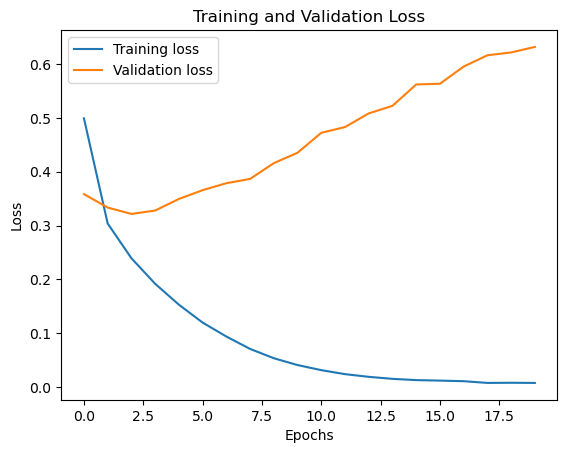

In [ ]:
# 학습 과정에서의 손실값과 검증 손실값을 시각화
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 모델을 사용하여 테스트 데이터셋에 대한 예측 수행
predicted_ratings = model.predict([test_text])

# 이진 분류 임계값 설정 (0.5 이상이면 1, 미만이면 0)
# 이를 통해 연속적인 예측 결과를 이진 값으로 변환
y_pred_binary = (predicted_ratings >= 0.5).astype(int)

# 모델 성능 평가를 위한 지표 계산: 정밀도, 재현율, F1 점수, 정확도
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

# 계산된 성능 지표를 백분율로 변환하여 출력
print(f"Precision: {precision*100:.2f}")
print(f"Recall: {recall*100:.2f}")
print(f"F1 Score: {f1*100:.2f}")
print(f"Accuracy: {accuracy*100:.2f}")

625/625 [==============================] - 2s 3ms/step
Precision: 86.93
Recall: 85.85
F1 Score: 86.39
Accuracy: 86.47
